In [9]:
import tensorflow as tf
from tensorflow import keras
import zipfile
import os
import shutil
import matplotlib.pyplot as plt

1. Download data of "Cats vs Dogs" dataset from: (https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip)

2. Place it in the same file as this notebook
3. Run the notebook

In [10]:
pre_trained_model = keras.applications.inception_v3.InceptionV3(
    input_shape=(150, 150, 3), 
    include_top=False, 
    weights=None)

pre_trained_model.load_weights("./inception_v3_weights.h5")

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [12]:
# pre_trained_model.summary()

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

print('Last layer output shape: ', last_layer.output_shape)

Last layer output shape:  (None, 7, 7, 768)


In [14]:
from tensorflow.keras import optimizers, losses, Model

# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = keras.layers.Dense(units=1024, activation=tf.nn.relu)(x)               
# Add a final sigmoid layer for classification
x = keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.binary_crossentropy,
    metrics=['accuracy'])

In [15]:
zip_ref = zipfile.ZipFile('./cats_vs_dogs.zip')
zip_ref.extractall('data')
zip_ref.close()

base = './data'
data_path = os.path.join(base,'PetImages')

In [16]:
def split_data(source, train, test, split_size):
    files = []
    for filename in os.listdir(source):
        filepath = os.path.join(source, filename)
        if os.path.getsize(filepath) > 0:
            files.append(filename)
        else:
            print("File has zero length, so ignoring it: (" + filename + ")")
    
    train_length = int(len(files) * split_size)
    test_length = len(files) - train_length
    
    train_filenames = files[0:train_length]
    test_filenames = files[-test_length:]
    
    for filename in train_filenames:
        src_path = os.path.join(source, filename)
        dest_path = os.path.join(train, filename)
        shutil.copyfile(src_path, dest_path)
    
    for filename in test_filenames:
        src_path = os.path.join(source, filename)
        dest_path = os.path.join(test, filename)
        shutil.copyfile(src_path, dest_path)

In [17]:
def make_dirs(root_dir):
    test_dir = os.path.join(root_dir, "test")
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        os.makedirs(os.path.join(test_dir, 'cats'))
        os.makedirs(os.path.join(test_dir, 'dogs'))
    
    train_dir = os.path.join(root_dir, "train")
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
        os.makedirs(os.path.join(train_dir, 'cats'))
        os.makedirs(os.path.join(train_dir, 'dogs'))
    
make_dirs(base)

In [18]:
train_dir = os.path.join(base, 'train')
test_dir = os.path.join(base, 'test')
if os.path.exists(train_dir) and os.path.exists(test_dir):
    shutil.rmtree(train_dir)
    shutil.rmtree(test_dir)
    make_dirs(base)

SPLIT_SIZE = 0.9
split_data(os.path.join(data_path, 'Cat'), os.path.join(train_dir, 'cats'), os.path.join(test_dir, 'cats'), SPLIT_SIZE)
split_data(os.path.join(data_path, 'Dog'), os.path.join(train_dir, 'dogs'), os.path.join(test_dir, 'dogs'), SPLIT_SIZE)

File has zero length, so ignoring it: (666.jpg)
File has zero length, so ignoring it: (11702.jpg)


In [19]:
from tensorflow.keras.preprocessing import image

train_gen = image.ImageDataGenerator(rescale=1/255.0,
                                    rotation_range=40,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode="nearest")

validation_gen = image.ImageDataGenerator(rescale=1/255.0)

In [20]:
import math

TRAIN_NUMBER_OF_IMAGES = 22498
TRAIN_BATCH_SIZE = 20
TRAIN_STEPS_PER_EPOCH = 100 # math.floor(TRAIN_NUMBER_OF_IMAGES / TRAIN_BATCH_SIZE)

TEST_NUMBER_OF_IMAGES = 2500
TEST_BATCH_SIZE = 20
TEST_STEPS_PER_EPOCH = 50 # math.floor(TRAIN_NUMBER_OF_IMAGES / TRAIN_BATCH_SIZE)

In [21]:
train_generator = train_gen.flow_from_directory(train_dir,
                             target_size=(150,150),
                             batch_size=TRAIN_BATCH_SIZE,
                             class_mode='binary')

validation_generator = validation_gen.flow_from_directory(test_dir,
                             target_size=(150,150),
                             batch_size=TEST_BATCH_SIZE,
                             class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=TEST_STEPS_PER_EPOCH)

Epoch 1/20


2022-03-18 15:23:19.378709: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-18 15:23:20.920857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.8590

2022-03-18 15:23:33.446949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 16s 112ms/step - loss: 0.5636 - accuracy: 0.8590 - val_loss: 0.1147 - val_accuracy: 0.9500
Epoch 2/20
100/100 [==============================] - 11s 107ms/step - loss: 0.2413 - accuracy: 0.9020 - val_loss: 0.0916 - val_accuracy: 0.9650
Epoch 3/20
100/100 [==============================] - 11s 107ms/step - loss: 0.1887 - accuracy: 0.9250 - val_loss: 0.0979 - val_accuracy: 0.9570
Epoch 4/20
100/100 [==============================] - 11s 106ms/step - loss: 0.1730 - accuracy: 0.9300 - val_loss: 0.1035 - val_accuracy: 0.9630
Epoch 5/20
100/100 [==============================] - 11s 107ms/step - loss: 0.1864 - accuracy: 0.9220 - val_loss: 0.0710 - val_accuracy: 0.9690
Epoch 6/20
100/100 [==============================] - 9s 92ms/step - loss: 0.1592 - accuracy: 0.9335 - val_loss: 0.0725 - val_accuracy: 0.9700
Epoch 7/20
100/100 [==============================] - 10s 97ms/step - loss: 0.1371 - accuracy: 0.9419 - val_loss: 0.0829 - val_accuracy: 0.9710

/Users/artem/miniforge3/envs/mlp/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 9s 90ms/step - loss: 0.1415 - accuracy: 0.9420 - val_loss: 0.0903 - val_accuracy: 0.9680
Epoch 9/20
100/100 [==============================] - 9s 91ms/step - loss: 0.1584 - accuracy: 0.9370 - val_loss: 0.0834 - val_accuracy: 0.9610
Epoch 10/20
100/100 [==============================] - 10s 96ms/step - loss: 0.1721 - accuracy: 0.9315 - val_loss: 0.0925 - val_accuracy: 0.9700
Epoch 11/20
100/100 [==============================] - 9s 92ms/step - loss: 0.1673 - accuracy: 0.9255 - val_loss: 0.0811 - val_accuracy: 0.9680
Epoch 12/20
100/100 [==============================] - 9s 90ms/step - loss: 0.1389 - accuracy: 0.9410 - val_loss: 0.0941 - val_accuracy: 0.9670
Epoch 13/20
100/100 [==============================] - 10s 97ms/step - loss: 0.1381 - accuracy: 0.9360 - val_loss: 0.0677 - val_accuracy: 0.9760
Epoch 14/20
100/100 [==============================] - 10s 95ms/step - loss: 0.1430 - accuracy: 0.9390 - val_loss: 0.0571 - val_accuracy: 0.9790
Ep

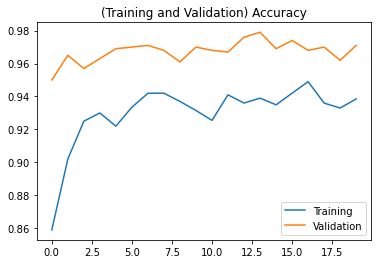

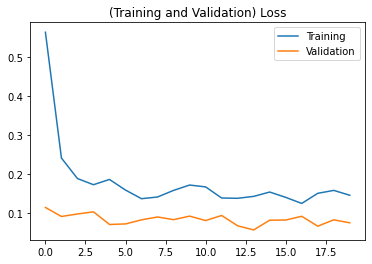

<Figure size 432x288 with 0 Axes>

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

line1, = plt.plot(epochs, acc, label="Training")
line2, = plt.plot(epochs, val_acc, label="Validation")
plt.legend(handles=[line1, line2])
plt.title("(Training and Validation) Accuracy")
plt.figure()

line1, = plt.plot(epochs, loss, label="Training")
line2, = plt.plot(epochs, val_loss, label="Validation")
plt.legend(handles=[line1, line2])
plt.title("(Training and Validation) Loss")
plt.figure()

plt.show()